# Camera Unit Alignement on Spectrogrpah Module
see PFS SpS Spectral channel alignment procedure iss2.0

In [1]:
%load_ext autoreload
 
%autoreload 2

In [2]:
from datetime import datetime
import os
import pandas as pd
import math
import numpy as np

In [3]:
import lsst.daf.persistence as dafPersist
import lsst.afw.display as afwDisplay
from pfs.drp.stella import DetectorMap
from pfs.drp.stella.utils import addPfsCursor
from pfs.datamodel.pfsConfig import *


In [4]:
from pfs.drp.stella.utils import showDetectorMap

In [5]:
afwDisplay.setDefaultBackend("matplotlib")

In [6]:
from align import *

In [7]:
from pfs.lam.opdb import getVisitRange
from pfs.lam.imageAnalysis import estimateCOM, fitparabola
from pfs.lam.linePeaksList import filterPeakList

In [8]:
import matplotlib.pyplot as plt

#plt.rcParams["figure.facecolor"] = "white" 

In [9]:
%matplotlib ipympl

In [10]:
datetime.now().strftime("%Y-%m-%dT%Hh%M")

'2023-11-09T09h55'

In [11]:
#define where plots will be saved
imgPath = "/work/fmadec/analysis/sm1/"

In [12]:
if os.path.exists(imgPath) is False:
    print(f"create foler {imgPath}")
    os.makedirs(imgPath, exist_ok=True)

create foler /work/fmadec/analysis/sm1/


In [13]:
savePlot = False

# Butler and Data
Define: ExpId/visitId arm and specId

In [22]:
base, rerun = "/work/drp/", "drpActor/CALIB"
#base, rerun = "/data/drp/sps", "fmadec/sm2/r2"


dataDir = os.path.join(base, "rerun", rerun) if rerun else base
calibRoot = "/work/drp/CALIB/"

butler = dafPersist.Butler(dataDir) #, calibRoot=calibRoot)

/tmp/ipykernel_130977/4064802442.py:8: FutureWarning: Gen2 Butler has been deprecated (PfsMapper). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  butler = dafPersist.Butler(dataDir) #, calibRoot=calibRoot)


lsst.CameraMapper INFO: Loading exposure registry from /work/drp/registry.pgsql
lsst.CameraMapper INFO: Loading calib registry from /work/drp/CALIB/calibRegistry.sqlite3
lsst.CameraMapper INFO: Loading calib registry from /work/drp/CALIB/calibRegistry.sqlite3


In [15]:
site = "Subaru"
specId = 1
arm = "n"
#expId = 3396
cam = f"{arm}{specId}"

In [158]:
LAMlines = pd.read_csv("/home/fmadec/SM2_LAM_nirJan2023_peakList.csv")


In [121]:
LAMlines.lamp.unique()

array(['Kr', 'Ar', 'Xe'], dtype=object)

In [ ]:
visitStart, visitEnd = getVisitRange(expId)
print(visitStart, visitEnd)

In [153]:
visit = 101771

In [154]:
dataId = dict(visit=visit, arm=arm, spectrograph=specId)
exp = butler.get("calexp", dataId)

In [155]:
# detectormap
detMap = butler.get('detectorMap', dataId)
# or 
#detMap = DetectorMap.readFits("/work/drp/rerun/fmadec/sm1/bootstrap/DETECTORMAP/pfsDetectorMap-101767-n1.fits")

simMap = DetectorMap.readFits("/work/drp//CALIB/DETECTORMAP/pfsDetectorMap-000000-n1.fits")
    

In [160]:
#rbutler = dafPersist.Butler(f"{dataDir}")
butler.getKeys('raw')
lamps = butler.queryMetadata('raw', ['lamps'], visit=visit, arm=arm) 
print(lamps)

['Ar']


In [156]:
pfsConfig = butler.get("pfsConfig", dataId).select(spectrograph=specId)
pfsConfig = pfsConfig[pfsConfig.targetType == TargetType.DCB]
fiberIds = pfsConfig.fiberId[pfsConfig.spectrograph == specId]

/work/stack_INFRA-312/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/drp_stella/w.2023.37/python/pfs/drp/stella/utils/display.py:219: UserWarning: addPfsCursor: Using an old version of display_matplotlib. Ideally need one that has the method DisplayImpl.set_format_coord. Using workaround.
  warnings.warn("addPfsCursor: Using an old version of display_matplotlib. "


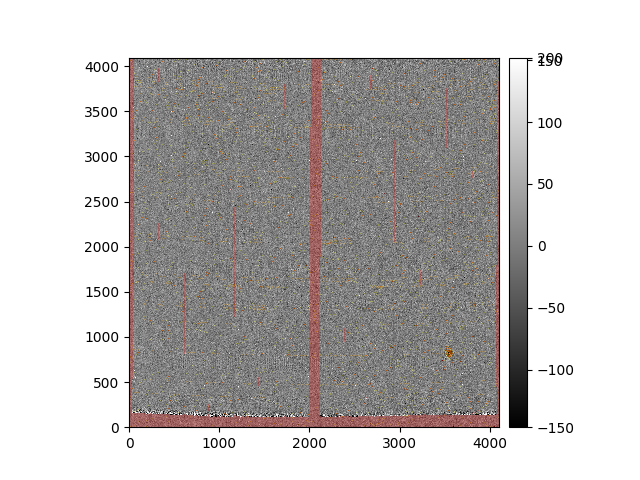

In [157]:
fig = 1; plt.close(fig); fig = plt.figure(fig)

display = afwDisplay.Display(fig)
display.scale("linear", min="zscale")
display.mtv(exp)
addPfsCursor(display, detectorMap=detMap)

In [ ]:
from pfs.drp.stella.referenceLine import ReferenceLineStatus
status = ReferenceLineStatus.LAM_FOCUS | ReferenceLineStatus.LAM_IMAGEQUALITY  # Selecting both kinds of LAM flags
#select = (lines.status & status) != 0  # Bit is set for status flags

In [142]:
from pfs.drp.stella.readLineList import ReadLineListTask
lines = ReadLineListTask().run(detectorMap=detMap, metadata=exp.getMetadata())
#select = (lines.status & status) != 0  # Bit is set for status flags

In [161]:
select = filterPeakList(LAMlines, arm, lamps)
select = select.wavelength.sort_values().unique()
select

array([ 966.0435,  978.7186, 1167.1904, 1240.6221, 1270.5756])

In [128]:
len(select)

9

In [55]:
select = LAMlines.wavelength.sort_values().unique()
select

array([ 966.0435 ,  970.688  ,  978.7186 ,  980.2384 ,  985.894  ,
        992.5919 , 1036.321  , 1087.788  , 1119.017  , 1146.0614 ,
       1167.1904 , 1179.564  , 1182.26136, 1220.78754, 1240.6221 ,
       1270.5756 ])

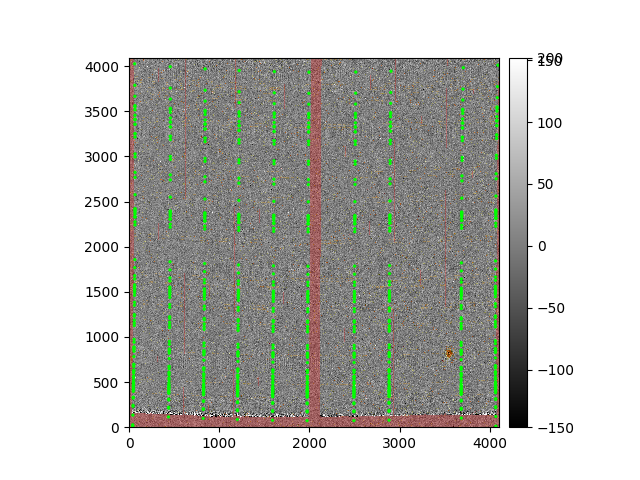

In [162]:
detMap.display(display, fiberId=pfsConfig.fiberId, wavelengths=lines.wavelength, plotTraces=False);
#detMap.display(display, fiberId=pfsConfig.fiberId, plotTraces=False);

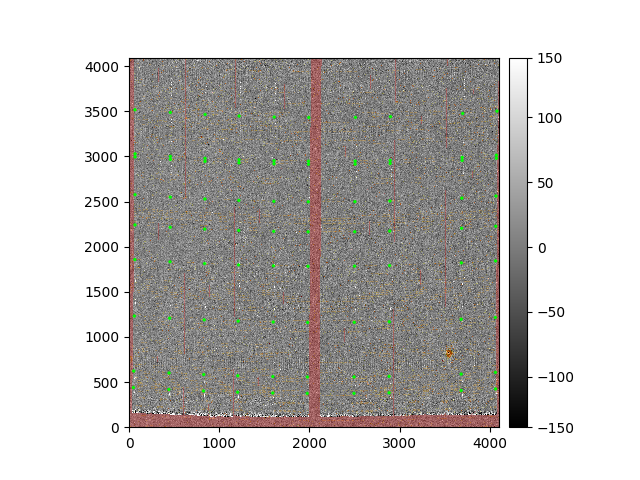

In [139]:
detMap.display(display, fiberId=pfsConfig.fiberId, wavelengths=select, plotTraces=False);
#detMap.display(display, fiberId=pfsConfig.fiberId, plotTraces=False);

/work/stack_INFRA-312/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/drp_stella/w.2023.37/python/pfs/drp/stella/utils/display.py:219: UserWarning: addPfsCursor: Using an old version of display_matplotlib. Ideally need one that has the method DisplayImpl.set_format_coord. Using workaround.
  warnings.warn("addPfsCursor: Using an old version of display_matplotlib. "


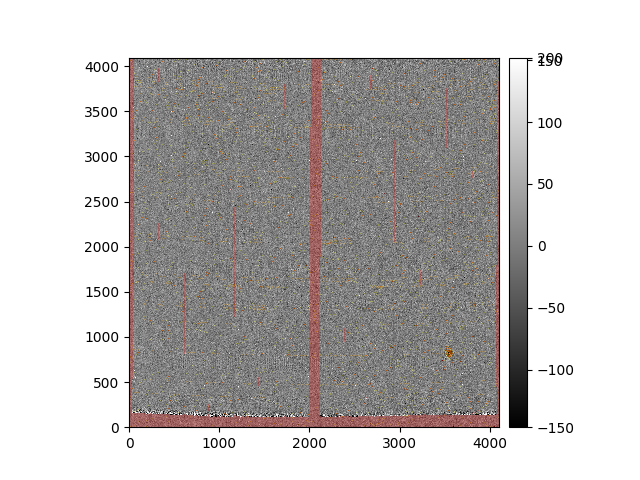

In [163]:
fig = 1; plt.close(fig); fig = plt.figure(fig)

display = afwDisplay.Display(fig)
display.scale("linear", min="zscale")
display.mtv(exp)
addPfsCursor(display, detectorMap=simMap)

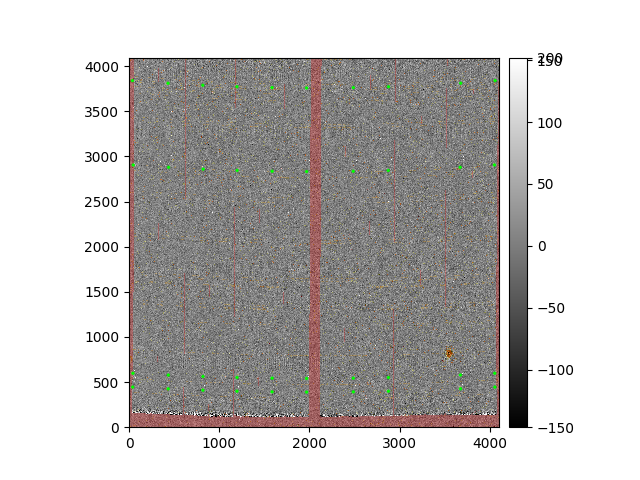

In [164]:
simMap.display(display, fiberId=pfsConfig.fiberId, wavelengths=select, plotTraces=False);
#detMap.display(display, fiberId=pfsConfig.fiberId, plotTraces=False);

In [ ]:
(lines.status & status)

In [ ]:
970+(1250-970)/2

# Camera Unit ROLL alignment
## Measure shift

In [27]:
RfrontBell=372.5 #rayon en mm


In [91]:
# Define center wavelenght to the corresponding arm
switchWave = {
    "r":[795.0362,826.6794],
    "b":0,
    "n":[1087.788  , 1119.017]
    }
midWaves  = switchWave.get(arm,"Invalid input" )

In [49]:
print(midWaves)

[1087.788, 1119.017]


/work/stack_INFRA-312/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/drp_stella/w.2023.37/python/pfs/drp/stella/utils/display.py:219: UserWarning: addPfsCursor: Using an old version of display_matplotlib. Ideally need one that has the method DisplayImpl.set_format_coord. Using workaround.
  warnings.warn("addPfsCursor: Using an old version of display_matplotlib. "


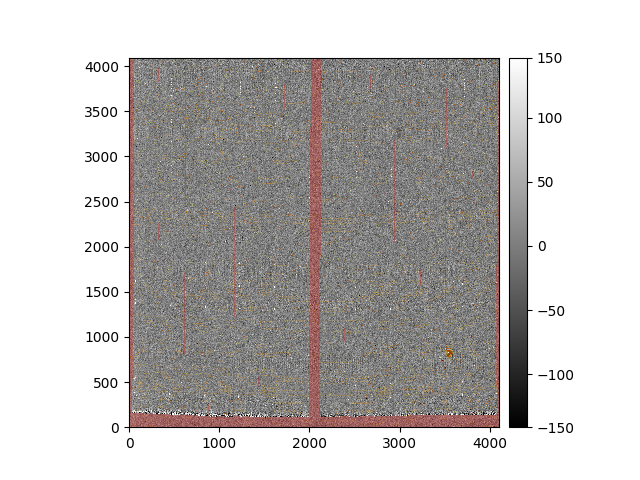

In [117]:
fig = 1; plt.close(fig); fig = plt.figure(fig)

display = afwDisplay.Display(fig)
display.scale("linear", min="zscale")
display.mtv(exp)
addPfsCursor(display, detectorMap=detMap)

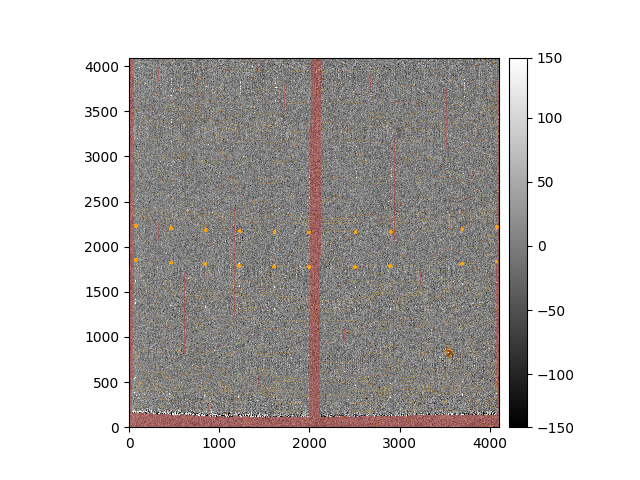

In [93]:
# overlay selected wave for each fiber used
ls = "+"
alpha = 0.5
color= "r"

with display.Buffering():
    for fiber in pfsConfig.fiberId:
        for midWave in midWaves:
            pt = detMap.findPoint(fiber, midWave)
            display.dot("+",pt.getX(), pt.getY(), size=10, ctype="orange")

        
        


In [52]:
# Retrieve position of this wave for each fiber 
# for calculation
data = []
for fiber in pfsConfig.fiberId:
    for midWave in midWaves:
        pt = detMap.findPoint(fiber, midWave)
        data.append({"fiberId": fiber, "wavelength": midWave, "x": pt.getX(), "y": pt.getY(), "fiber": fiber - (specId-1)*651  })
    

In [ ]:
df = pd.DataFrame.from_dict(data)

In [ ]:
# This is to show bother fiber and pixel on plot
# need a function to swith to fiber from px and inverse
# this is linear function
coef = np.polyfit(df.x, df.fiber, 1)

px2fiber = np.poly1d(coef)

coef = np.polyfit(df.fiber, df.x, 1)

fiber2px = np.poly1d(coef)

plt.figure()
plt.plot(df.fiber, df.x)
plt.plot(np.arange(0,650),fiber2px(np.arange(0,650)))

In [ ]:
annot, roll_shim, roll_angle = getRollCu(df, doPrint=True)

In [ ]:
roll_angle

### plot 

In [ ]:
fname = os.path.join(imgPath, f"{site}_SM{dataId['spectrograph']}_{dataId['arm'].upper()}{dataId['spectrograph']}_CURoll_before_{dataId['visit']}__{datetime.now().strftime('%Y-%m-%dT%Hh%M')}.png")
print(fname)

In [ ]:
plot_CU_roll(df, dataId, midWaves, doPrint=True, fname=fname, doSavePlot=savePlot, px2fiber=px2fiber, fiber2px=fiber2px )

## Do the Cameara Unit Roll adjustment

### found peak centration after alignment
the peak (fiver, wave) position will move with the aligmnent, but not so far from the original position
so we try to find the peak position in a roi (region of interest) around the original position

roi_size can be adjusted, value by defaut is 15 px

In [ ]:
roi_size = 25

### Define VisitId after CU Roll alignment

In [ ]:
# Image after alignment
expId = 0
visit = 49518dispCURoll2.scale("linear", min="zscale")


In [ ]:
base, rerun = "/data/drp/sps", "ginga/detrend"

dataDir = os.path.join(base, "rerun", rerun) if rerun else base
calibRoot = "/data/drp/sps/CALIB/"

butler = dafPersist.Butler(dataDir) #, calibRoot=calibRoot)

In [ ]:
dataId = dict(visit=visit, arm=arm, spectrograph=specId)
exp = butler.get("calexp", dataId)

In [ ]:
fig = 2; plt.close(fig); fig = plt.figure(fig)

dispCURoll2 = afwDisplay.Display(fig)
dispCURoll2.scale("linear", min="zscale")

dispCURoll2.mtv(exp)

In [ ]:
dispCURoll2.erase

In [ ]:
afterData = []
for name, group in df.groupby(["fiber", "wavelength"]):
    [fiberId] = group["fiberId"].values
    [wave] = group["wavelength"].values
    [fiber] = group["fiber"].values
    [x0] =  group["x"].values
    [y0] =  group["y"].values
    x, y = estimateCOM(exp.image.array, x0, y0, roi_size=roi_size, doBck=True)
    afterData.append({"fiberId": fiberId, "wavelength": wave, "x": x, "y": y, "fiber": fiber })
    print(fiber, wave, x-x0, y-y0)

In [ ]:
# overlay selected wave for each fiber used
ls = "+"
alpha = 0.5
color= "r"

with dispCURoll2.Buffering():
    for origi, val in zip(data, afterData):
        dispCURoll2.dot("o",origi['x'], origi['y'], size=roi_size, ctype="red")
        dispCURoll2.dot("x",val['x'], val['y'], size=10, ctype="red")

        
        


In [ ]:
df_after = pd.DataFrame.from_dict(afterData)

In [ ]:
annot, roll_shim, roll_angle = getRollCu(df_after, doPrint=True)

In [ ]:
plot_CU_roll(df_after,dataId, midWaves, site=site, fname=None, doSavePlot=None )

In [ ]:
fname = os.path.join(imgPath, f"{site}_SM{dataId['spectrograph']}_{dataId['arm'].upper()}{dataId['spectrograph']}_CURoll_after_{dataId['visit']}__{datetime.now().strftime('%Y-%m-%dT%Hh%M')}.png")
print(fname)

In [ ]:
plot_CU_roll(df_after,dataId, midWaves, site=site, fname=fname, doSavePlot=savePlot )

# VPGH Roll adjustment

According PFS SUMIRE Spectrographs subassemblies user manual WS276-001-USM001-X (draft)

See section 8.6 p 21

>VPGH slope setting is 0.867 arsec / µm  |  Range is +/-1° | Accuracy <10 arsec

Calculation is done using a central fiber (#315). One way is to use a spectral lamp (Hg-Ar) and find each peak positions and calulate the angle between first and least peak.

goal is to be within one pixel

## Data required
* either you have a **detectorMap**, so you took an Arc and a Trace to bootstrap **detectorMap** after the CU Roll alignment 
* or **estimateCom** will be used to found current peak positions from the first boostraped **detectorMap**

In [ ]:
VPHG_Set = 0.867 # arsec / µm

In [ ]:
df.fiber.unique()

In [ ]:
# Define which central fibers Id will be used
# ideally one on each chip for VIS CU
centFibers = [339]

## Measure before alignment

In [ ]:
# Image before alignment
expId = 0
visit = 49518

In [ ]:
base, rerun = "/data/drp/sps", "ginga/detrend"

dataDir = os.path.join(base, "rerun", rerun) if rerun else base
calibRoot = "/data/drp/sps/CALIB/"

butler = dafPersist.Butler(dataDir) #, calibRoot=calibRoot)

In [ ]:
dataId = dict(visit=visit, arm=arm, spectrograph=specId)
exp = butler.get("calexp", dataId)

In [ ]:
lamps = butler.queryMetadata('raw', ['lamps'], dataId)
print(lamps)

In [ ]:
dMapUse = True

In [ ]:
# detectormap
#detMap = butler.get('detectorMap', dataId)
# or 
#detMap = DetectorMap.readFits("/data/drp/sps/CALIB/DETECTORMAP/pfsDetectorMap-045367-n2.fits")
detMap = DetectorMap.readFits("/data/drp/sps/rerun/fmadec/r2/bootstrap/DETECTORMAP/pfsDetectorMap-049518-r2.fits")

    

In [ ]:
fig = 3; plt.close(fig); fig = plt.figure(fig)

dispVPHG = afwDisplay.Display(fig)
dispVPHG.scale("linear", min="zscale")
dispVPHG.mtv(exp)

In [ ]:
waves = filterPeakList(LAMlines, arm, lamps[0]).wavelength.unique()

In [ ]:
waves

In [ ]:
centFibers

In [ ]:
vphg = []
if dMapUse is True:
    data = []
    for wave in waves:
        for fiber in centFibers:
            pt = detMap.findPoint(fiber + (specId-1)*651, wave)
            vphg.append({"fiberId": fiber + (specId-1)*651, "wavelength": wave, "x": pt.getX(), "y": pt.getY(), "fiber": fiber})

In [ ]:
# overlay selected wave for each fiber used
dotColor = "darkgreen"
with dispVPHG.Buffering():
    for  val in vphg:
        dispVPHG.dot("x",val['x'], val['y'], size=10, ctype=dotColor)

        
        


In [ ]:
dfVPHG = pd.DataFrame.from_dict(vphg).sort_values("y")
dfVPHG

In [ ]:
shiftPx = 0
shiftPy = 0

In [ ]:
if dMapUse is False:
    
    vphg = []
    for name, group in dfVPHG.groupby(["fiber", "wavelength"]):
        [fiberId] = group["fiberId"].values
        [wave] = group["wavelength"].values
        [fiber] = group["fiber"].values
        [x0] =  group["x"].values + shiftPx
        [y0] =  group["y"].values + shiftPy
        x, y = estimateCOM(exp.image.array, x0, y0, roi_size=roi_size, doBck=True)
        vphg.append({"fiberId": fiberId, "wavelength": wave, "x": x, "y": y, "fiber": fiber })
        print(fiber, wave, x-x0, y-y0)

In [ ]:
sdata = dfVPHG
fname=0
#fiber_name = 339

In [ ]:
fname = os.path.join(imgPath, f"{site}_SM{dataId['spectrograph']}_{dataId['arm'].upper()}{dataId['spectrograph']}_VPHGRoll_before_{dataId['visit']}__{datetime.now().strftime('%Y-%m-%dT%Hh%M')}.png")
print(fname)

In [ ]:
vphgRollShim = plot_vphg_roll(dfVPHG, dataId, centFibers, site=site, fname=fname, doSavePlot=savePlot)

In [ ]:
currentMeasure = 81.21 # mm

print(f"Value wanted: {currentMeasure + vphgRollShim*1e-3:.2f} mm")

In [ ]:
currentMeasure = 80.95 # mm

print(f"Value wanted: {currentMeasure + vphgRollShim*1e-3:.2f} mm")

In [ ]:
roi_size = 15

### Define VisitId after VPHG Roll alignment

In [ ]:
# Image after alignment
expId = 0
visit = 49520

In [ ]:
dataId = dict(visit=visit, arm=arm, spectrograph=specId)
exp = butler.get("calexp", dataId)

In [ ]:
fig = 4; plt.close(fig); fig = plt.figure(fig)

dispVPHGRoll2 = afwDisplay.Display(fig)
dispVPHGRoll2.scale("linear",  min="zscale")
dispVPHGRoll2.mtv(exp)



## Do the VPHG alignment 
### Measure after alignment

In [ ]:
detMap = DetectorMap.readFits("/data/drp/sps/rerun/fmadec/r2/bootstrap/DETECTORMAP/pfsDetectorMap-049520-r2.fits")


In [ ]:
vphgAfter = []
if dMapUse is True:
    data = []
    for wave in waves:
        for fiber in centFibers:
            pt = detMap.findPoint(fiber + (specId-1)*651, wave)
            vphgAfter.append({"fiberId": fiber + (specId-1)*651, "wavelength": wave, "x": pt.getX(), "y": pt.getY(), "fiber": fiber})
            


In [ ]:
roi_size = 15
seek_size = None

shiftPx = +25
shiftPy = 0

In [ ]:

vphgAfter = []
for name, group in dfVPHG.groupby(["fiber", "wavelength"]):
    [fiberId] = group["fiberId"].values
    [wave] = group["wavelength"].values
    [fiber] = group["fiber"].values
    [x0] =  group["x"].values + shiftPx
    [y0] =  group["y"].values + shiftPy
    x, y = estimateCOM(exp.image.array, x0, y0, roi_size=roi_size, doBck=True, seek_size=seek_size)
    vphgAfter.append({"fiberId": fiberId, "wavelength": wave, "x": x, "y": y, "fiber": fiber })
    print(fiber, wave, x-x0, y-y0)

In [ ]:
# overlay selected wave for each fiber used
ls = "+"
alpha = 0.5
color= "r"

with dispVPHGRoll2.Buffering():
    for origi, val in zip(vphg, vphgAfter):
        dispVPHGRoll2.dot("o",origi['x'], origi['y'], size=roi_size, ctype="red")
        dispVPHGRoll2.dot("x",val['x'], val['y'], size=10, ctype="darkorange")

        
        


In [ ]:
dfVPHGAfter = pd.DataFrame.from_dict(vphgAfter).sort_values("y")
dfVPHGAfter

In [ ]:
fname = os.path.join(imgPath, f"{site}_SM{dataId['spectrograph']}_{dataId['arm'].upper()}{dataId['spectrograph']}_VPHGRoll_After_{dataId['visit']}__{datetime.now().strftime('%Y-%m-%dT%Hh%M')}.png")
print(fname)

In [ ]:
vphgRollShim = plot_vphg_roll(dfVPHGAfter, dataId, centFibers, site=site, fname=fname, doSavePlot=savePlot)

In [ ]:
np.rad2deg(math.atan(0.8/3052))*3600*VPHG_Set


In [ ]:
math.atan(0.8/3052)

In [ ]:
vphgRollShim

In [ ]:
currentMeasure = 80.30 # mm

print(f"Value wanted: {currentMeasure + vphgRollShim*1e-3:.2f} mm")

In [ ]:
currentMeasure = 80.43 # mm

print(f"Value wanted: {currentMeasure + vphgRollShim*1e-3:.2f} mm")

In [ ]:
from scipy.stats import sigmaclip

In [ ]:
df = dfVPHGAfter
fibers = centFibers
fig, ax = plt.subplots(figsize=(12,8))
plt.grid()

plt.xlabel("X pixel")
plt.ylabel("Y pixel")
plt.title(f"{site} - SM{dataId['spectrograph']} - {dataId['arm'].upper()}{dataId['spectrograph']} - VPHG Roll adjustment \n visitId = {dataId['visit']}")


x0 = df.x.values[0] 



lns1 = ax.plot( df.x, df.y, 'o', label=f"{*fibers,}", color="black")

fact = 2
c, low, upp = sigmaclip(df.x, fact, fact)
dffit = df[df.x.isin(c)]

# fit data 
popt = np.polyfit( dffit.x, dffit.y, 1)
print(popt)
t = np.arange(df.x.min(), df.x.max()+0.1)
lns2 = ax.plot(t,np.polyval(popt, t), 'b--', label="linear fit")

annot = f"Shift { df.x.max() - df.x.min():.1f} px over {df.y.max() - df.y.min():.1f} px \n" 

Roll_VPHG_shim_fit = np.rad2deg(1/popt[0])*3600*VPHG_Set
annot += f"VPHG Roll Shim: {Roll_VPHG_shim_fit:.0f} um \n"

print(np.rad2deg(popt[0])*3600*VPHG_Set)

print(annot)

plt.annotate(annot, xy=(.58,.2),xycoords="figure fraction")

lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)


if False:
#fig.patch.set_alpha(0.5)
    plt.savefig(fname)
#        plt.savefig(fname, transparent=True)


# Camera Unit Vertical tilt Alignment

In [ ]:
# for Vis CU horizontal is along X axis

In [74]:
# Image before alignment
expId = 0
visit = 101767

In [75]:
base, rerun = "/work/drp/", "drpActor/CALIB"
#base, rerun = "/data/drp/sps", "fmadec/sm2/r2"


dataDir = os.path.join(base, "rerun", rerun) if rerun else base
calibRoot = "/work/drp/CALIB/"

butler = dafPersist.Butler(dataDir) #, calibRoot=calibRoot)

lsst.CameraMapper INFO: Loading exposure registry from /work/drp/registry.pgsql
lsst.CameraMapper INFO: Loading calib registry from /work/drp/CALIB/calibRegistry.sqlite3
lsst.CameraMapper INFO: Loading calib registry from /work/drp/CALIB/calibRegistry.sqlite3


In [76]:
dataId = dict(visit=visit, arm=arm, spectrograph=specId)
exp = butler.get("calexp", dataId)

In [77]:
pfsConfig = butler.get("pfsConfig", dataId).select(spectrograph=specId)
pfsConfig = pfsConfig[pfsConfig.targetType == TargetType.DCB]
fiberIds = pfsConfig.fiberId[pfsConfig.spectrograph == specId]

In [78]:
# detectormap

simMap = DetectorMap.readFits("/work/drp//CALIB/DETECTORMAP/pfsDetectorMap-000000-n1.fits")
# bootstrapped detectorMap (after previous alignment)

#detMap = DetectorMap.readFits("/data/drp/sps/rerun/fmadec/r2/bootstrap/DETECTORMAP/pfsDetectorMap-049795-r2.fits")

    

/work/stack_INFRA-312/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/drp_stella/w.2023.37/python/pfs/drp/stella/utils/display.py:219: UserWarning: addPfsCursor: Using an old version of display_matplotlib. Ideally need one that has the method DisplayImpl.set_format_coord. Using workaround.
  warnings.warn("addPfsCursor: Using an old version of display_matplotlib. "


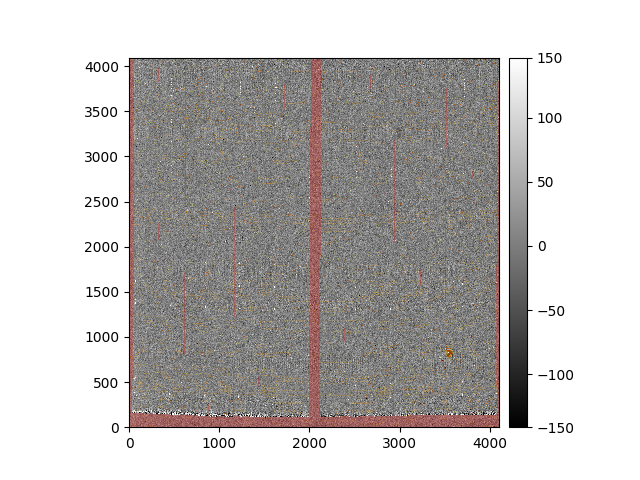

In [79]:
fig = 3; plt.close(fig); fig = plt.figure(fig)

dispHTilt = afwDisplay.Display(fig)
dispHTilt.scale("linear",  min="zscale")

dispHTilt.mtv(exp)
addPfsCursor(dispHTilt, detMap)


In [80]:
# Retrieve position of this wave for each fiber 
# for calculation
simdata = []
for fiber in pfsConfig.fiberId:
    for midWave in midWaves:
        pt = simMap.findPoint(fiber, midWave)
        simdata.append({"fiberId": fiber, "wavelength": midWave, "x": pt.getX(), "y": pt.getY(), "fiber": fiber - (specId-1)*651  })
    

In [81]:
sim = pd.DataFrame.from_dict(simdata)

In [83]:
# Retrieve position of this wave for each fiber 
# for calculation
data = []
for fiber in pfsConfig.fiberId:
    for midWave in midWaves:
        pt = detMap.findPoint(fiber, midWave)
        data.append({"fiberId": fiber, "wavelength": midWave, "x": pt.getX(), "y": pt.getY(), "fiber": fiber - (specId-1)*651  })
    

In [84]:
df = pd.DataFrame.from_dict(data)

In [85]:
data=df[df.wavelength == midWaves[0]]
fitparabola(data.x, data.y)

x            y
0       72.843641  1848.655281
1       73.243591  1848.627226
2       73.643542  1848.599176
3       74.043492  1848.571132
4       74.443442  1848.543092
...           ...          ...
9995  4070.348152  1835.008947
9996  4070.748102  1835.034277
9997  4071.148053  1835.059612
9998  4071.548003  1835.084952
9999  4071.947954  1835.110298

[10000 rows x 2 columns]

In [86]:
naxis1 = exp.getDimensions().getX() #px
naxis2 = exp.getDimensions().getY() #px
#pix_size = 15 #µm

In [87]:
xsize = exp.getDimensions().getX()
ysize = exp.getDimensions().getY()
F_CU = 300. #mm
pix_size = 15e-3
e = 523.639 #mm entraxe en sperolinders de la CU

In [88]:
def getTiltCUShim(shift, doPrint=True):
    '''
    shift in pixel
    '''
    F_CU = 300. #mm
    pix_size = 15e-3
    e = 523.639 #mm entraxe en sperolinders de la CU
    shift_mm = shift * pix_size
    shim = e*shift_mm/F_CU
    if doPrint:
        annot = "CU tilt \n"
        annot += "Shift %.2f px\n"%shift
        annot += "Shift %.2f microns\n"%(shift*15)
        annot += "angle %.3f deg\n"%(math.degrees(math.atan(shift_mm/F_CU)))
        annot += "angle %.3f arsec\n"%(math.degrees(math.atan(shift_mm/F_CU))*3600)
        annot += "shim %.3f mm"%(e*shift_mm/F_CU)
        print(annot)
    return 

In [89]:
color="b"

CU vertical tilt 
Center 2173.78 
Shift -125.78 px
Shift -1886.75 microns
angle -0.360 deg
angle -1297.216 arsec
shim -3.293 mm


'    \naxy = ax.twinx()\nlns2 = axy.plot("x", "y", "*", label=f"{midWaves[1]}nm", data=df[df.wavelength == midWaves[1]], color="r")\ndata = df[df.wavelength == midWaves[1]]\nparab = fitparabola(data.x, data.y)\nlns2p = axy.plot("x", "y", "--", label=f"fit {midWaves[1]}nm", data =parab , c="r")\n# added these three lines\nlns = lns1+lns2+lns1p+lns2p\nlabs = [l.get_label() for l in lns]\nax.legend(lns, labs, loc=0)\n'

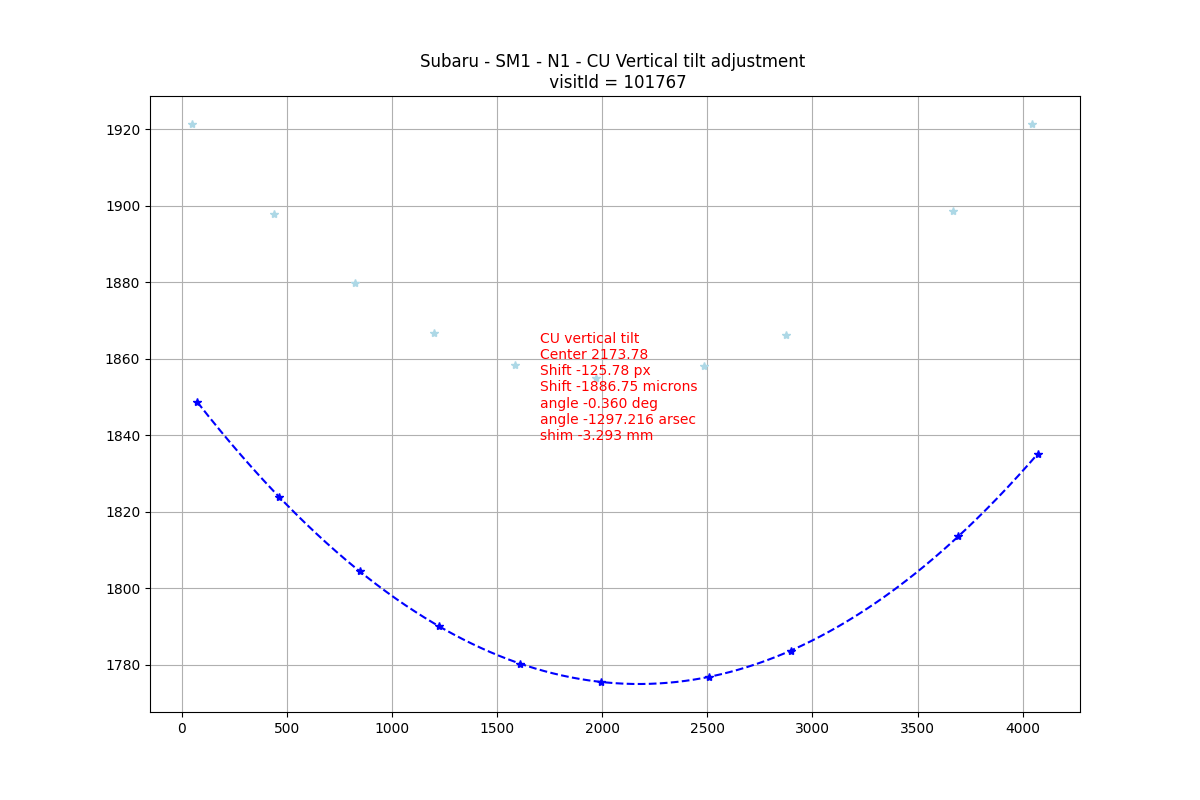

In [94]:
fig, ax = plt.subplots(figsize=(12,8))
plt.grid()
plt.title(f"{site} - SM{dataId['spectrograph']} - {dataId['arm'].upper()}{dataId['spectrograph']} - CU Vertical tilt adjustment \n visitId = {dataId['visit']}")

lns1 = ax.plot("x", "y", "*", label=f"{midWaves[0]}nm", data=df[df.wavelength == midWaves[0]], c="b")
ax.plot("x", "y", "*", label=f"{midWaves[0]}nm", data=sim[sim.wavelength == midWaves[0]], c="lightblue")

#secax = ax.secondary_xaxis(1, functions=(px2fiber, fiber2px))
#secax.set_xlabel('Fiber')
data = df[df.wavelength == midWaves[0]]
parab = fitparabola(data.x, data.y)
lns1p = ax.plot("x", "y", "--", label=f"fit {midWaves[0]}nm", data =parab , c="b")


center = parab.focus
xshift = xsize/2 - center
xshift_mm = xshift*pix_size


annot = "CU vertical tilt \n"
annot += "Center %.2f \n"%center
annot += "Shift %.2f px\n"%xshift
annot += "Shift %.2f microns\n"%(xshift*15)
annot += "angle %.3f deg\n"%(math.degrees(math.atan(xshift_mm/F_CU)))
annot += "angle %.3f arsec\n"%(math.degrees(math.atan(xshift_mm/F_CU))*3600)
annot += "shim %.3f mm"%(e*xshift_mm/F_CU)

print(annot)


ax.annotate(annot,  xy=(.45,.45),xycoords="figure fraction", color=color)

'''    
axy = ax.twinx()
lns2 = axy.plot("x", "y", "*", label=f"{midWaves[1]}nm", data=df[df.wavelength == midWaves[1]], color="r")
data = df[df.wavelength == midWaves[1]]
parab = fitparabola(data.x, data.y)
lns2p = axy.plot("x", "y", "--", label=f"fit {midWaves[1]}nm", data =parab , c="r")
# added these three lines
lns = lns1+lns2+lns1p+lns2p
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)
'''

In [ ]:
getTiltCUShim(-3)

## After ajustment

In [ ]:
# Image before alignment
expId = 0
visit = 48886

In [ ]:
base, rerun = "/data/drp/sps", "ginga/detrend"

dataDir = os.path.join(base, "rerun", rerun) if rerun else base
calibRoot = "/data/drp/sps/CALIB/"

butler = dafPersist.Butler(dataDir) #, calibRoot=calibRoot)

In [ ]:
dataId = dict(visit=visit, arm=arm, spectrograph=specId)
exp = butler.get("calexp", dataId)

In [ ]:
pfsConfig = butler.get("pfsConfig", dataId).select(spectrograph=specId)

In [ ]:
# detectormap

simMap = DetectorMap.readFits("/data/drp/sps/CALIB/DETECTORMAP/pfsDetectorMap-000000-r4.fits")
# bootstrapped detectorMap (after previous alignment)

#detMap = DetectorMap.readFits("/data/drp/sps/rerun/fmadec/n2/bootstrap/DETECTORMAP/pfsDetectorMap-048879-n2.fits")
#detMap = DetectorMap.readFits("/data/drp/sps/rerun/fmadec/n2/bootstrap/DETECTORMAP/pfsDetectorMap-048886-n2.fits")
#detMap = DetectorMap.readFits("/data/drp/sps/rerun/fmadec/n2/bootstrap/DETECTORMAP/pfsDetectorMap-048888-n2.fits")


    

In [ ]:
fig = 3; plt.close(fig); fig = plt.figure(fig)

dispHTilt2 = afwDisplay.Display(fig)
dispHTilt2.scale("linear",  min="zscale")

dispHTilt2.mtv(exp)
addPfsCursor(dispHTilt2, detMap)


In [ ]:
# Retrieve position of this wave for each fiber 
# for calculation
simdata = []
for fiber in pfsConfig.fiberId:
    for midWave in midWaves:
        pt = simMap.findPoint(fiber, midWave)
        simdata.append({"fiberId": fiber, "wavelength": midWave, "x": pt.getX(), "y": pt.getY(), "fiber": fiber - (specId-1)*651  })
    

In [ ]:
sim = pd.DataFrame.from_dict(simdata)

In [ ]:
# Retrieve position of this wave for each fiber 
# for calculation
data = []
for fiber in pfsConfig.fiberId:
    for midWave in midWaves:
        pt = detMap.findPoint(fiber, midWave)
        data.append({"fiberId": fiber, "wavelength": midWave, "x": pt.getX(), "y": pt.getY(), "fiber": fiber - (specId-1)*651  })
    

In [ ]:
df = pd.DataFrame.from_dict(data)

In [ ]:
naxis1 = exp.getDimensions().getX() #px
naxis2 = exp.getDimensions().getY() #px
pix_size = 15 #µm

In [ ]:
xsize = exp.getDimensions().getX()
ysize = exp.getDimensions().getY()
F_CU = 300. #mm
pix_size = 15e-3
e = 523.639 #mm entraxe en sperolinders de la CU

In [ ]:
print(xsize, ysize)

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
plt.grid()
plt.title(f"{site} - SM{dataId['spectrograph']} - {dataId['arm'].upper()}{dataId['spectrograph']} - CU Roll adjustment \n visitId = {dataId['visit']}")

lns1 = ax.plot("x", "y", "*", label=f"{midWaves[0]}nm", data=df[df.wavelength == midWaves[0]], c="b")
secax = ax.secondary_xaxis(1, functions=(px2fiber, fiber2px))
secax.set_xlabel('Fiber')
data = df[df.wavelength == midWaves[0]]
parab = fitparabola(data.x, data.y)
lns1p = ax.plot("x", "y", "--", label=f"fit {midWaves[0]}nm", data =parab , c="b")


center = parab.focus
xshift = xsize/2 - center
xshift_mm = xshift*pix_size


annot = "CU vertical tilt \n"
annot += "Center %.2f \n"%center
annot += "Shift %.2f px\n"%xshift
annot += "Shift %.2f microns\n"%(xshift*15)
annot += "angle %.3f deg\n"%(math.degrees(math.atan(xshift_mm/F_CU)))
annot += "angle %.3f arsec\n"%(math.degrees(math.atan(xshift_mm/F_CU))*3600)
annot += "shim %.3f mm"%(e*xshift_mm/F_CU)

print(annot)


ax.annotate(annot,  xy=(.45,.45),xycoords="figure fraction", color=color)

    
axy = ax.twinx()
lns2 = axy.plot("x", "y", "*", label=f"{midWaves[1]}nm", data=df[df.wavelength == midWaves[1]], color="r")
data = df[df.wavelength == midWaves[1]]
parab = fitparabola(data.x, data.y)
lns2p = axy.plot("x", "y", "--", label=f"fit {midWaves[1]}nm", data =parab , c="r")
# added these three lines
lns = lns1+lns2+lns1p+lns2p
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
plt.grid()
plt.title(f"{site} - SM{dataId['spectrograph']} - {dataId['arm'].upper()}{dataId['spectrograph']} - CU Roll adjustment \n visitId = {dataId['visit']}")

lns1 = ax.plot("x", "y", "*", label=f"{midWaves[0]}nm", data=df[df.wavelength == midWaves[0]], c="b")
secax = ax.secondary_xaxis(1, functions=(px2fiber, fiber2px))
secax.set_xlabel('Fiber')
data = df[df.wavelength == midWaves[0]]
parab = fitparabola(data.x, data.y)
lns1p = ax.plot("x", "y", "--", label=f"fit {midWaves[0]}nm", data =parab , c="b")

In [ ]:
center = parab.focus
xshift = xsize/2 - center
xshift_mm = xshift*pix_size


annot = "CU vertical tilt \n"
annot += "Center %.2f \n"%center
annot += "Shift %.2f px\n"%xshift
annot += "Shift %.2f microns\n"%(xshift*15)
annot += "angle %.3f deg\n"%(math.degrees(math.atan(xshift_mm/F_CU)))
annot += "angle %.3f arsec\n"%(math.degrees(math.atan(xshift_mm/F_CU))*3600)
annot += "shim %.3f mm"%(e*xshift_mm/F_CU)

print(annot)


ax.annotate(annot,  xy=(.45,.45),xycoords="figure fraction", color=color)

    
axy = ax.twinx()
lns2 = axy.plot("x", "y", "*", label=f"{midWaves[1]}nm", data=df[df.wavelength == midWaves[1]], color="r")
data = df[df.wavelength == midWaves[1]]
parab = fitparabola(data.x, data.y)
lns2p = axy.plot("x", "y", "--", label=f"fit {midWaves[1]}nm", data =parab , c="r")
# added these three lines
lns = lns1+lns2+lns1p+lns2p
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)

In [ ]:
4096/2

In [ ]:
parab.focus

In [ ]:
plot_CU_roll(df, dataId, midWaves)

# Spectrum alignment on detector

In [ ]:
detMap.getWavelength()

In [97]:
waveLow = 940
waveHigh = 1260
waveMid = waveLow + (waveHigh -  waveLow)/2

In [98]:
dim = exp.getDimensions()

In [99]:
dim.getX()

4096

In [100]:
naxis1 = exp.getDimensions().getX() #px
naxis2 = exp.getDimensions().getY() #px
pix_size = 15 #µm

In [101]:
ft = 2 + (specId-1)*651
yLow_fib2 = int(detMap.findPoint(ft,waveLow).getY()) #ftFunction.yCenter + ftFunction.yLow
yHigh_fib2 = int(detMap.findPoint(ft,waveHigh).getY())

ft = 650+ (specId-1)*651
yLow_fib650 = int(detMap.findPoint(ft,waveLow).getY()) #ftFunction.yCenter + ftFunction.yLow
yHigh_fib650 = int(detMap.findPoint(ft,waveHigh).getY())


ValueError: cannot convert float NaN to integer

In [102]:
waveMid = waveLow + (waveHigh - waveLow) /2.
ft = 2 + (specId-1)*651
xMed_fib2 = int(detMap.findPoint(ft,waveMid).getX()) #ftFunction.yCenter + ftFunction.yLow

ft = 650 + (specId-1)*651
xMed_fib650 = int(detMap.findPoint(ft,waveMid).getX()) #ftFunction.yCenter + ftFunction.yLow

print(naxis1 - xMed_fib2, xMed_fib650)

# decenter is given by comparing the margin there between the side of the detector and spectrum of the 2 extermes sciences fibers 2 and 650
# xdim so naxis1 - x of fiber #2 for center wave 
# 

spatial_decenter = (naxis1 - xMed_fib2) - xMed_fib650
print(f"spatial decenter: {spatial_decenter}px")

ft = 650 + (specId-1)*651
yHigh_fib339 = int(detMap.findPoint(ft,waveLow).getY())
yLow_fib339 = int(detMap.findPoint(ft,waveHigh).getY())

spectral_decenter_ft650 = (naxis2 - yHigh_fib339) - yLow_fib339
print(f"spectral decenter: {spectral_decenter_ft650}px")

ft = 2 + (specId-1)*651
yHigh_fib339 = int(detMap.findPoint(ft,waveLow).getY())
yLow_fib339 = int(detMap.findPoint(ft,waveHigh).getY())

spectral_decenter_ft2 = (naxis2 - yHigh_fib339) - yLow_fib339
print(f"spectral decenter: {spectral_decenter_ft2}px")

24 73
spatial decenter: -49px
spectral decenter: 19px


ValueError: cannot convert float NaN to integer

In [ ]:
def plotDetAlign(detMap, specId=2):
    
    detMapvisitId = 0000
    
    waveMid = waveLow + (waveHigh - waveLow) /2.
    ft = 2 + (specId-1)*651
    xMed_fib2 = int(detMap.findPoint(ft,waveMid).getX()) #ftFunction.yCenter + ftFunction.yLow

    ft = 650 + (specId-1)*651
    xMed_fib650 = int(detMap.findPoint(ft,waveMid).getX()) #ftFunction.yCenter + ftFunction.yLow

    print(naxis1 - xMed_fib2, xMed_fib650)

    # decenter is given by comparing the margin there between the side of the detector and spectrum of the 2 extermes sciences fibers 2 and 650
    # xdim so naxis1 - x of fiber #2 for center wave 
    # 

    spatial_decenter = (naxis1 - xMed_fib2) - xMed_fib650
    print(f"spatial decenter: {spatial_decenter}px")

    ft = 650 + (specId-1)*651
    yHigh_fib339 = int(detMap.findPoint(ft,waveLow).getY())
    yLow_fib339 = int(detMap.findPoint(ft,waveHigh).getY())

    spectral_decenter_ft650 = (naxis2 - yHigh_fib339) - yLow_fib339
    print(f"spectral decenter: {spectral_decenter_ft650}px")

    ft = 2 + (specId-1)*651
    yHigh_fib339 = int(detMap.findPoint(ft,waveLow).getY())
    yLow_fib339 = int(detMap.findPoint(ft,waveHigh).getY())

    spectral_decenter_ft2 = (naxis2 - yHigh_fib339) - yLow_fib339
    print(f"spectral decenter: {spectral_decenter_ft2}px")

    
    fig, ax = plt.subplots(figsize=(12,8))
    
    ft = 2 + (specId-1)*651
    xCenters = detMap.getXCenter(ft)
    yLow = int(detMap.findPoint(ft,waveLow).getY()) #ftFunction.yCenter + ftFunction.yLow
    yHigh = int(detMap.findPoint(ft,waveHigh).getY())
    print(yLow, yHigh)
    offset = 0
    print(detMap.findWavelength(ft,yLow+offset ))
    ax.plot(xCenters[yLow+offset:yHigh], np.arange(yLow, yHigh), color="red", linestyle='--')
    ax.annotate(f"fiber {ft}",  xy=(.85,.5),xycoords="figure fraction", color="red")
    ax2 =ax.twinx()
    xCenters = detMap.getXCenter(ft)
    w = detMap.getWavelength(ft)
    ax2.plot(xCenters[yLow+offset:yHigh], w[yLow+offset:yHigh], color="red")


    ft = 650 + (specId-1)*651
    xCenters = detMap.getXCenter(ft)
    yLow = int(detMap.findPoint(ft,waveLow).getY()) #ftFunction.yCenter + ftFunction.yLow
    yHigh = int(detMap.findPoint(ft,waveHigh).getY())
    print(yLow, yHigh)
    offset = 0
    print(detMap.findWavelength(ft,yLow+offset ))
    ax.plot(xCenters[yLow+offset:yHigh], np.arange(yLow, yHigh), color="blue")
    ax.annotate(f"fiber {ft}",  xy=(.1,.5),xycoords="figure fraction", color="blue")
    xCenters = detMap.getXCenter(ft)
    w = detMap.getWavelength(ft)
    ax2.plot(xCenters[yLow+offset:yHigh], w[yLow+offset:yHigh], color="blue")

    edgeX = []
    edgeY = []

    for f in detMap.getFiberId():
        edgeX.append(detMap.findPoint(f,waveLow).getX())
        edgeY.append(detMap.findPoint(f,waveLow).getY()) 
    ax.plot(edgeX, edgeY, color="green")
    ax.annotate(f"{waveLow}nm",  xy=(.5,.1),xycoords="figure fraction", color="green")

    #ax3 = ax.twiny()
    #ax3.plot(detMap.getFiberId(), edgeY)
    edgeX = []
    edgeY = []

    for f in detMap.getFiberId():
        edgeX.append(detMap.findPoint(f,waveHigh).getX())
        edgeY.append(detMap.findPoint(f,waveHigh).getY()) 
    ax.plot(edgeX, edgeY, color="purple")
    ax.annotate(f"{waveHigh}nm",  xy=(.5,.9),xycoords="figure fraction", color="purple")

    #ax3.plot(detMap.getFiberId(), edgeY)

    ax.set_xlim(1,4095 )
    ax.set_ylim(1,4176 )
    #ax3.set_xlim(detMap.getFiberId()[-1], detMap.getFiberId()[0])
    ax.set_xlabel("pixel x")
    ax.set_ylabel("pixel y")
    ax2.set_ylabel("Wavelength (nm)")
    plt.annotate(f"Spatial decenter at mid wavelength {waveMid:.1f}nm = {spatial_decenter}px ({spatial_decenter*pix_size:.1f}µm)", (0.3, 0.5), xycoords="figure fraction")
    plt.annotate(f"Spectral decenter at \n(fiber 2, {waveLow:.1f}nm) = {spectral_decenter_ft2}px ({spectral_decenter_ft2*pix_size:.1f}µm)", (0.65, 0.2), xycoords="figure fraction")
    plt.annotate(f"Spectral decenter at \n(fiber 650, {waveLow:.1f}nm) = {spectral_decenter_ft650}px ({spectral_decenter_ft650*pix_size:.1f}µm)", (0.15, 0.2), xycoords="figure fraction")

    plt.title(f"{cam.upper()} centering - detectorMap {detMapvisitId}")
    #plt.savefig(imgPath+f"{cam.upper()}centering-detectorMap{detMapvisitId}"+".png", bbox_inches = "tight")
    return

In [ ]:
pix_size

TypeError: cannot unpack non-iterable NoneType object

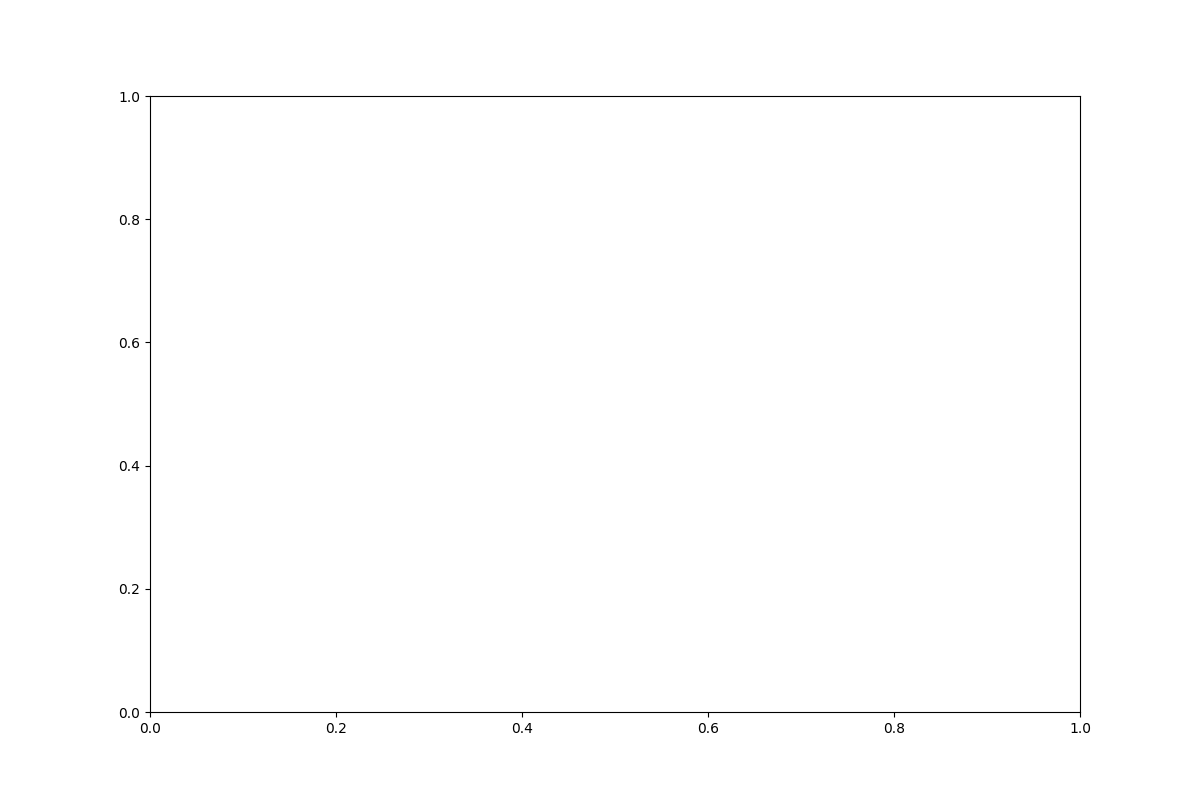

In [113]:
fig, ax = plt.subplots(figsize=(12,8))
#fname = os.path.join(imgPath,f"{cam.upper()}centering-detectorMap{detMapvisitId}"+".png")
fname = os.path.join(imgPath, f"{site}_SM{dataId['spectrograph']}_{dataId['arm'].upper()}{dataId['spectrograph']}_CU_detMap_before_{dataId['visit']}__{datetime.now().strftime('%Y-%m-%dT%Hh%M')}.png")

out = plotReqDetAlignAxe(detMap, ax=ax, simMap=None, doSavePlot=False, fname=fname)

TypeError: plotReqDetAlignAxe() got an unexpected keyword argument 'pixel'

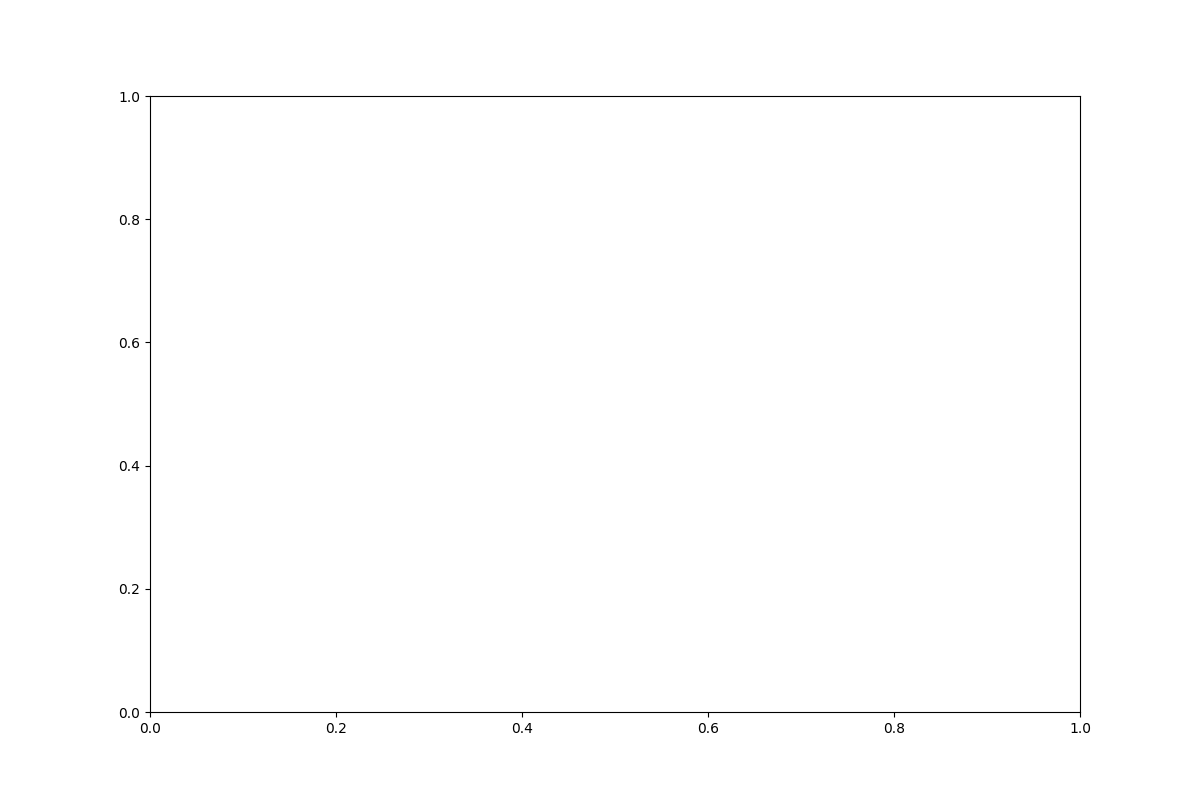

In [111]:
fig, ax = plt.subplots(figsize=(12,8))
#fname = os.path.join(imgPath,f"{cam.upper()}centering-detectorMap{detMapvisitId}"+".png")
fname = os.path.join(imgPath, f"{site}_SM{dataId['spectrograph']}_{dataId['arm'].upper()}{dataId['spectrograph']}_CU_detMap_before_{dataId['visit']}__{datetime.now().strftime('%Y-%m-%dT%Hh%M')}.png")

out = plotReqDetAlignAxe(detMap, ax=ax, simMap=None, doSavePlot=False, fname=fname, pixel=False)

In [ ]:
simMap.getXCenter(2603)

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
#fname = os.path.join(imgPath,f"{cam.upper()}centering-detectorMap{detMapvisitId}"+".png")
fname = os.path.join(imgPath, f"{site}_SM{dataId['spectrograph']}_{dataId['arm'].upper()}{dataId['spectrograph']}_CU_detMap_before_{dataId['visit']}__{datetime.now().strftime('%Y-%m-%dT%Hh%M')}.png")
print(fname)
print(fname)
print(fname)
out = plotDetAlignAxe(detMap, ax=ax, simMap=simMap, doSavePlot=True, fname=fname, fibers=[2,650], specId=specId, waves=[waveLow, waveMid, waveHigh])

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
#fname = os.path.join(imgPath,f"{cam.upper()}centering-detectorMap{detMapvisitId}"+".png")
fname = os.path.join(imgPath, f"{site}_SM{dataId['spectrograph']}_{dataId['arm'].upper()}{dataId['spectrograph']}_CU_detMap_before_{dataId['visit']}__{datetime.now().strftime('%Y-%m-%dT%Hh%M')}.png")
print(fname)
print(fname)
print(fname)
out = plotDetAlignAxe(detMap, ax=ax, simMap=simMap, doSavePlot=True, fname=fname, fibers=[2,650], specId=specId, waves=[waveLow, waveMid, waveHigh])

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
#fname = os.path.join(imgPath,f"{cam.upper()}centering-detectorMap{detMapvisitId}"+".png")
fname = os.path.join(imgPath, f"{site}_SM{dataId['spectrograph']}_{dataId['arm'].upper()}{dataId['spectrograph']}_CU_detMap_before_{dataId['visit']}__{datetime.now().strftime('%Y-%m-%dT%Hh%M')}.png")
print(fname)
print(fname)
print(fname)
out = plotDetAlignAxe(detMap, ax=ax, simMap=simMap, doSavePlot=True, fname=fname, fibers=[2,650], specId=specId, waves=[waveLow, waveMid, waveHigh])

In [103]:
#fig, ax = plt.subplots(figsize=(12,8))
#fname = os.path.join(imgPath,f"{cam.upper()}centering-detectorMap{detMapvisitId}"+".png")
fname = os.path.join(imgPath, f"{site}_SM{dataId['spectrograph']}_{dataId['arm'].upper()}{dataId['spectrograph']}_CU_detMap_before_{dataId['visit']}__{datetime.now().strftime('%Y-%m-%dT%Hh%M')}.png")
print(fname)

out = plotDetAlign(detMap, specId=specId, waves=[waveLow, waveMid, waveHigh])

/work/fmadec/analysis/sm1/Subaru_SM1_N1_CU_detMap_before_101767__2023-11-09T11h31.png
24 73
spatial decenter: -49px
spectral decenter: 19px


ValueError: cannot convert float NaN to integer

In [ ]:
detMap.getBBox()

In [95]:
getOffsets(detMap, specId=specId, simMap=simMap, waves=[waveLow, waveMid, waveHigh])

NameError: name 'getOffsets' is not defined

In [ ]:
infos = [
        {"fiber": 2, "color": "red", "annot": (.85,.5)},
        {"fiber": 650, "color": "blue", "annot": (.1,.5)}
        ]

In [ ]:
[item for item in infos if item["fiber"]]

In [ ]:
[d['fiber'] for d in infos if 'fiber' in d]

fiber: 1


ValueError: cannot convert float NaN to integer

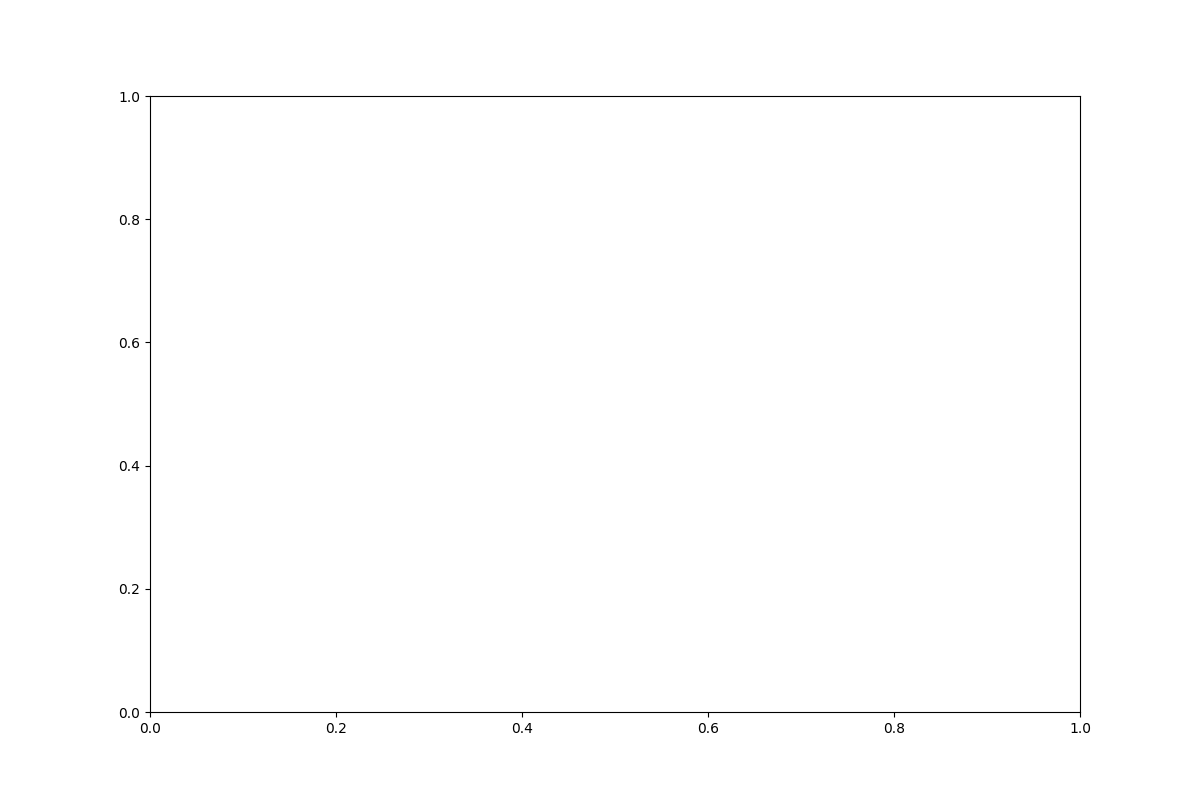

In [115]:
fig, ax = plt.subplots(figsize=(12,8))
plotDetMapContour(detMap, specId=specId, ax=ax, waves=[waveLow, waveMid, waveHigh])

In [ ]:
offsets = getOffsets(detMap, specId=specId, simMap=simMap, waves=[waveLow, waveMid, waveHigh])

In [ ]:
#[item for item in offsets if item["fiber"] == 2]

for offset in offsets:
    print(offset)




In [ ]:
detMap.metadata.toDict()

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
out = plotDetAlignAxe(detMap, ax=ax, simMap=simMap)

In [ ]:
def plotDetAlignAxe(detMap, specId=2, ax=None, data=True):
    pix_size = 15
    if data is True:
        ls = '-'
        alpha = 1
    else:
        ls = '--'
        alpha = 0.3

    detMapvisitId = 0000
    
    waveMid = waveLow + (waveHigh - waveLow) /2.
    ft = 1 + (specId-1)*651
    xMed_fib2 = int(detMap.findPoint(ft,waveMid).getX()) #ftFunction.yCenter + ftFunction.yLow

    ft = 651 + (specId-1)*651
    xMed_fib650 = int(detMap.findPoint(ft,waveMid).getX()) #ftFunction.yCenter + ftFunction.yLow

    print(naxis1 - xMed_fib2, xMed_fib650)

    # decenter is given by comparing the margin there between the side of the detector and spectrum of the 2 extermes sciences fibers 2 and 650
    # xdim so naxis1 - x of fiber #2 for center wave 
    # 

    spatial_decenter = (naxis1 - xMed_fib2) - xMed_fib650
    print(f"spatial decenter: {spatial_decenter}px")

    ft = 651 + (specId-1)*651
    yHigh_fib339 = int(detMap.findPoint(ft,waveLow).getY())
    yLow_fib339 = int(detMap.findPoint(ft,waveHigh).getY())

    spectral_decenter_ft650 = (naxis2 - yHigh_fib339) - yLow_fib339
    print(f"spectral decenter: {spectral_decenter_ft650}px")

    ft = 1 + (specId-1)*651
    yHigh_fib339 = int(detMap.findPoint(ft,waveLow).getY())
    yLow_fib339 = int(detMap.findPoint(ft,waveHigh).getY())

    spectral_decenter_ft2 = (naxis2 - yHigh_fib339) - yLow_fib339
    print(f"spectral decenter: {spectral_decenter_ft2}px")
    
    ft = 339 + (specId-1)*651
    yHigh_fib339 = int(detMap.findPoint(ft,waveLow).getY())
    yLow_fib339 = int(detMap.findPoint(ft,waveHigh).getY())

    spectral_decenter_ft339 = (naxis2 - yHigh_fib339) - yLow_fib339
    print(f"spectral decenter: {spectral_decenter_ft339}px")

    ft = 2 + (specId-1)*651
    xMid_fib2 = int(detMap.findPoint(2+(specId-1)*651,waveMid).getX())
    yMid_fib650 = int(detMap.findPoint(650+(specId-1)*651,waveMid).getX())
    spectral_decenter_mid = (xMid_fib2 - yMid_fib650 - naxis1)/2
    print(f"spatial Mid decenter: {spectral_decenter_mid}px")

    if ax is None:
        fig, ax = plt.subplots(figsize=(12,8))
    
    ft = 1 + (specId-1)*651
    xCenters = detMap.getXCenter(ft)
    yLow = int(detMap.findPoint(ft,waveLow).getY()) #ftFunction.yCenter + ftFunction.yLow
    yHigh = int(detMap.findPoint(ft,waveHigh).getY())
    print(yLow, yHigh)
    offset = 0
    print(detMap.findWavelength(ft,yLow+offset ))
    ax.plot(xCenters[yLow+offset:yHigh], np.arange(yLow, yHigh), color="red", linestyle=ls, alpha=alpha)
    if data is True:
        ax.annotate(f"fiber {ft}",  xy=(.85,.5),xycoords="figure fraction", color="red")
    #ax2 =ax.twinx()
    xCenters = detMap.getXCenter(ft)
    w = detMap.getWavelength(ft)
    #ax2.plot(xCenters[yLow+offset:yHigh], w[yLow+offset:yHigh], color="red")


    ft = 651 + (specId-1)*651
    xCenters = detMap.getXCenter(ft)
    yLow = int(detMap.findPoint(ft,waveLow).getY()) #ftFunction.yCenter + ftFunction.yLow
    yHigh = int(detMap.findPoint(ft,waveHigh).getY())
    print(yLow, yHigh)
    offset = 0
    print(detMap.findWavelength(ft,yLow+offset ))
    ax.plot(xCenters[yLow+offset:yHigh], np.arange(yLow, yHigh), color="blue", linestyle=ls, alpha=alpha)
    if data is True:
        ax.annotate(f"fiber {ft}",  xy=(.1,.5),xycoords="figure fraction", color="blue")
    xCenters = detMap.getXCenter(ft)
    w = detMap.getWavelength(ft)
    #ax2.plot(xCenters[yLow+offset:yHigh], w[yLow+offset:yHigh], color="blue")

    edgeX = []
    edgeY = []

    for f in detMap.getFiberId():
        edgeX.append(detMap.findPoint(f,waveLow).getX())
        edgeY.append(detMap.findPoint(f,waveLow).getY()) 
    ax.plot(edgeX, edgeY, color="green", linestyle=ls, alpha=alpha)
    if data is True:
        ax.annotate(f"{waveLow}nm",  xy=(.5,.1),xycoords="figure fraction", color="green")

    #ax3 = ax.twiny()
    #ax3.plot(detMap.getFiberId(), edgeY)
    edgeX = []
    edgeY = []

    for f in detMap.getFiberId():
        edgeX.append(detMap.findPoint(f,waveHigh).getX())
        edgeY.append(detMap.findPoint(f,waveHigh).getY()) 
    ax.plot(edgeX, edgeY, color="purple", linestyle=ls, alpha=alpha)
    if data is True:
        ax.annotate(f"{waveHigh}nm",  xy=(.5,.9),xycoords="figure fraction", color="purple")

    edgeX = []
    edgeY = []

    for f in detMap.getFiberId():
        edgeX.append(detMap.findPoint(f,waveMid).getX())
        edgeY.append(detMap.findPoint(f,waveMid).getY()) 
    ax.plot(edgeX, edgeY, color="orange", linestyle=ls, alpha=alpha)
    if data is True:
        ax.annotate(f"{waveMid}nm",  xy=(.5,.45),xycoords="figure fraction", color="orange")

        
    #ax3.plot(detMap.getFiberId(), edgeY)

    ax.set_xlim(1,4095 )
    ax.set_ylim(1,4176 )
    #ax3.set_xlim(detMap.getFiberId()[-1], detMap.getFiberId()[0])
    ax.set_xlabel("pixel x")
    out = ax.set_ylabel("pixel y")
    #ax2.set_ylabel("Wavelength (nm)")
    if data is True:
        plt.annotate(f"Spatial decenter at mid wavelength {waveMid:.1f}nm = {spatial_decenter}px ({spatial_decenter*pix_size:.1f}µm)", (0.3, 0.5), xycoords="figure fraction")
        plt.annotate(f"Spectral decenter at \n(fiber 2, {waveLow:.1f}nm) = {spectral_decenter_ft2}px ({spectral_decenter_ft2*pix_size:.1f}µm)", (0.65, 0.2), xycoords="figure fraction")
        plt.annotate(f"Spectral decenter at \n(fiber 650, {waveLow:.1f}nm) = {spectral_decenter_ft650}px ({spectral_decenter_ft650*pix_size:.1f}µm)", (0.15, 0.2), xycoords="figure fraction")

    plt.title(f"{cam.upper()} centering - detectorMap {detMapvisitId}")
    #plt.savefig(imgPath+f"{cam.upper()}centering-detectorMap{detMapvisitId}"+".png", bbox_inches = "tight")
    return out

In [ ]:
getTiltCUShim(26)

In [ ]:
detMap

In [ ]:
plotDetAlign(detMap)

In [ ]:
spatial_decenter = -49

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
plt.grid()
xshift_mm = spatial_decenter*pix_size


annot = "CU horizontal tilt \n"
annot += "Shift %.2f px\n"%spatial_decenter
annot += "Shift %.2f microns\n"%(spatial_decenter*15)
annot += "angle %.3f deg\n"%(math.degrees(math.atan(xshift_mm/F_CU)))
annot += "angle %.3f arsec\n"%(math.degrees(math.atan(xshift_mm/F_CU))*3600)
annot += "shim %.3f mm"%(e*xshift_mm/F_CU)

print(annot)


ax.annotate(annot,  xy=(.45,.45),xycoords="figure fraction", color=color)

    
axy = ax.twinx()
lns2 = axy.plot("x", "y", "*", label=f"{midWaves[1]}nm", data=df[df.wavelength == midWaves[1]], color="r")
data = df[df.wavelength == midWaves[1]]
parab = fitparabola(data.x, data.y)
lns2p = axy.plot("x", "y", "--", label=f"fit {midWaves[1]}nm", data =parab , c="r")
# added these three lines
lns = lns1+lns2+lns1p+lns2p
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)

In [ ]:
detMap.findPoint(1301,1260).getX()

In [ ]:
detMap.findWavelength(652, 4095)

In [ ]:
detMap.findWavelength(650 + (specId-1)*651, 4095)

In [ ]:
detMap.getSpectralOffset(652)

In [ ]:
simMap.findWavelength(652, 4095)

In [ ]:
fig = 4; plt.close(fig); fig = plt.figure(fig)

dispDetMap = afwDisplay.Display(fig)

dispDetMap.mtv(exp)
addPfsCursor(dispDetMap, detMap)


In [ ]:
showDetectorMap(dispDetMap, pfsConfig, detMap)

In [ ]:
detMap.getWavelength()

In [ ]:
simMap.getWavelength()

In [106]:
max = 4067
min= 66

In [108]:
print(f"({naxis2} - {max}) - {min}")


(4096 - 4067) - 66


In [109]:
(4096 - 4067) - 66

-37